In [30]:
import re
import nltk
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from sklearn.linear_model import SGDClassifier
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import gensim
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_curve, f1_score, accuracy_score, recall_score, roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error, precision_score, recall_score, f1_score

In [2]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Dataset.tsv', sep='\t')
df.shape

Mounted at /content/drive


(99999, 2)

In [3]:
df.head(10)

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...
5,Positive,أسلوب الكاتب رائع جدا و عميق جدا، قرأته عدة مر...
6,Positive,استثنائي. الهدوء في الجناح مع مسبح. عدم وجود ع...
7,Positive,الكتاب هو السيرة الذاتية للحداثة في المملكة بل...
8,Positive,من أجمل ما قرأت.. رواية تستحق القراءة فعلا..
9,Positive,بشكل عام جيده .. . التجاوب جيد جدا من قبل موظف...


In [4]:
df['label'].value_counts()

Positive    33333
Mixed       33333
Negative    33333
Name: label, dtype: int64

In [5]:
df['label_id'] = df['label'].map({'Negative': 0, 'Positive': 1 , 'Mixed': 2})

In [6]:
df.iloc[70000:70010]

,label,text,label_id
70000,Negative,السجينة،،تعجبني جدا الروايات المقتبسة من قصص و...,0
70001,Negative,كفايه عليها نجمه واحده بقى. النجمه بتوفى بممكن...,0
70002,Negative,الحاجه اللى تضايق ان الرواية كانت ممكن تكون اف...,0
70003,Negative,الحمد لله رب العالمين. تلك الأيام وفتحى غانم ا...,0
70004,Negative,كتاب خفبف و مسلى و يتقرأ فى ساعه,0
70005,Negative,اسلوب احلام جميل كالعاده برومانسيتها وتصويرها ...,0
70006,Negative,قراتى للكتاب مجرد فضول منى وقولت اضحك شوية تغي...,0
70007,Negative,أفتقدت نزار في هذا الديوان,0
70008,Negative,بكره أحمد مراد,0
70009,Negative,هذه الرواية جميلة في اسلوبها تتنقل بين الغزل ا...,0


In [7]:
df['label'].value_counts()

Positive    33333
Mixed       33333
Negative    33333
Name: label, dtype: int64

In [8]:
# Download via terminal commands
!wget "https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip"
!unzip "full_grams_cbow_300_twitter.zip"

--2023-10-26 07:42:48--  https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip
Resolving bakrianoo.ewr1.vultrobjects.com (bakrianoo.ewr1.vultrobjects.com)... 108.61.0.122, 2001:19f0:0:22::100
Connecting to bakrianoo.ewr1.vultrobjects.com (bakrianoo.ewr1.vultrobjects.com)|108.61.0.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3325529808 (3.1G) [application/zip]
Saving to: ‘full_grams_cbow_300_twitter.zip’

full_grams_cbow_300 100%[===================>]   3.10G   132MB/s    in 30s     

2023-10-26 07:43:18 (105 MB/s) - ‘full_grams_cbow_300_twitter.zip’ saved [3325529808/3325529808]

Archive:  full_grams_cbow_300_twitter.zip
  inflating: full_grams_cbow_300_twitter.mdl  
  inflating: full_grams_cbow_300_twitter.mdl.trainables.syn1neg.npy  
  inflating: full_grams_cbow_300_twitter.mdl.wv.vectors.npy  


In [9]:
modelCBow = gensim.models.Word2Vec.load("full_grams_cbow_300_twitter.mdl")

In [10]:
# Clean/Normalize Arabic Text
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']

    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)

    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)

    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')

    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])

    #trim
    text = text.strip()

    return text

In [11]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
arabic_stop_words = set(stopwords.words('arabic'))

In [13]:
def preprocess_and_vectorize(text):
  # Remove Stop words and Lemmatize each word
  words = word_tokenize(clean_str(text))

  filtered_sentence = []

  for word in words:
      if word not in arabic_stop_words:

          filtered_sentence.append(word)
  if len(filtered_sentence)==0:
    return None
  return modelCBow.wv.get_mean_vector(filtered_sentence)

In [14]:
df['sentence_embedding'] = df['text'].apply(preprocess_and_vectorize)

In [15]:
df.isnull().sum()

label                  0
text                   0
label_id               0
sentence_embedding    14
dtype: int64

In [16]:
df.dropna(subset=['sentence_embedding'], inplace=True)
df.isnull().sum()

label                 0
text                  0
label_id              0
sentence_embedding    0
dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99985 entries, 0 to 99998
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   label               99985 non-null  object
 1   text                99985 non-null  object
 2   label_id            99985 non-null  int64 
 3   sentence_embedding  99985 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.8+ MB


In [18]:
X_train, X_test, y_train, y_test = train_test_split(df['sentence_embedding'].values, df['label_id'], test_size=0.1, stratify=df['label_id'], random_state=42)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((89986,), (9999,), (89986,), (9999,))

In [20]:
X_train = np.stack(X_train)
X_test =  np.stack(X_test)

In [21]:
X_train.shape, X_test.shape

((89986, 300), (9999, 300))

In [22]:
def get_accuracy(name, trained_model , x_train, y_train, x_test, y_test):
    tree_predict = trained_model.predict(x_test)
    print("Testing accuracy   :",metrics.accuracy_score(y_test, tree_predict)*100 , "%")
    print("MSE [TEST]          :",mean_squared_error(y_test, tree_predict))


    tree_predict1 = trained_model.predict(x_train)
    print("Training accuracy  :",metrics.accuracy_score(y_train, tree_predict1)*100 ,"%")
    print("MSE [TRAIN]         :",mean_squared_error(y_train, tree_predict1))

    print("precision : ",precision_score(y_test, tree_predict,average='micro'))
    print("recall    : ",recall_score(y_test, tree_predict,average='micro'))
    print("f1_score  : ",f1_score(y_test, tree_predict,average='micro'))


    cf1 = confusion_matrix(y_test,tree_predict)
    sns.heatmap(cf1,annot=True,fmt = '.0f')
    plt.xlabel('prediction')
    plt.ylabel('Actual')
    plt.title(name+ ' Confusion Matrix')
    plt.show()

    print(classification_report(y_train,  trained_model.predict(X_train)))
    print(classification_report(y_test,  trained_model.predict(X_test)))

Testing accuracy   : 56.14561456145615 %
MSE [TEST]          : 0.8435843584358436
Training accuracy  : 56.5832462827551 %
MSE [TRAIN]         : 0.8241281977196453
precision :  0.5614561456145615
recall    :  0.5614561456145615
f1_score  :  0.5614561456145615


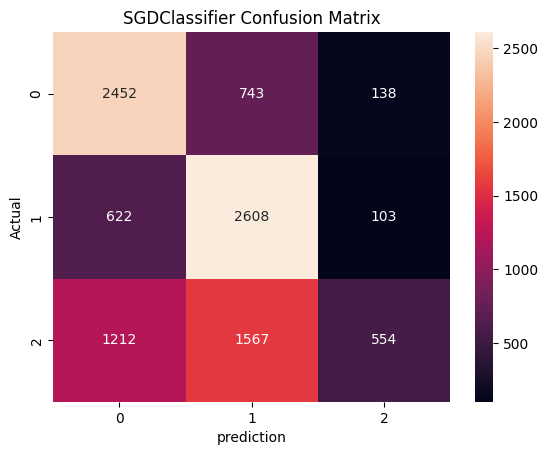

              precision    recall  f1-score   support

           0       0.58      0.73      0.65     29995
           1       0.53      0.79      0.63     29996
           2       0.70      0.17      0.28     29995

    accuracy                           0.57     89986
   macro avg       0.60      0.57      0.52     89986
weighted avg       0.60      0.57      0.52     89986

              precision    recall  f1-score   support

           0       0.57      0.74      0.64      3333
           1       0.53      0.78      0.63      3333
           2       0.70      0.17      0.27      3333

    accuracy                           0.56      9999
   macro avg       0.60      0.56      0.51      9999
weighted avg       0.60      0.56      0.51      9999



In [23]:
trained_clf_sgd = SGDClassifier(loss='hinge', alpha=0.001, random_state=42).fit(X_train, y_train)
get_accuracy('SGDClassifier',trained_clf_sgd,X_train, y_train, X_test, y_test)


Testing accuracy   : 56.82568256825683 %
MSE [TEST]          : 0.9336933693369337
Training accuracy  : 99.927766541462 %
MSE [TRAIN]         : 0.0011557353366079169
precision :  0.5682568256825683
recall    :  0.5682568256825683
f1_score  :  0.5682568256825683


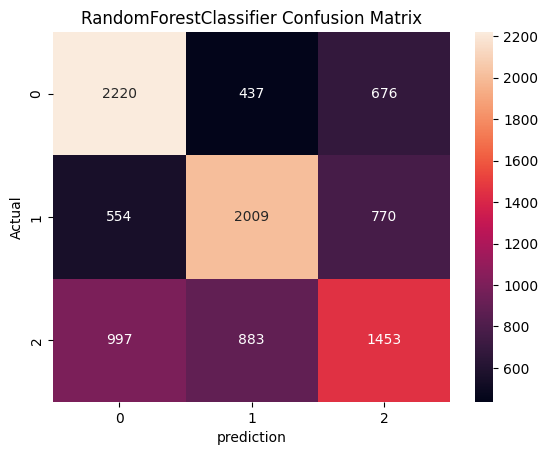

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29995
           1       1.00      1.00      1.00     29996
           2       1.00      1.00      1.00     29995

    accuracy                           1.00     89986
   macro avg       1.00      1.00      1.00     89986
weighted avg       1.00      1.00      1.00     89986

              precision    recall  f1-score   support

           0       0.59      0.67      0.62      3333
           1       0.60      0.60      0.60      3333
           2       0.50      0.44      0.47      3333

    accuracy                           0.57      9999
   macro avg       0.56      0.57      0.56      9999
weighted avg       0.56      0.57      0.56      9999



In [24]:
trained_clf_random_forest = RandomForestClassifier().fit(X_train, y_train)
get_accuracy('RandomForestClassifier',trained_clf_random_forest,X_train, y_train, X_test, y_test)

Testing accuracy   : 60.68606860686069 %
MSE [TEST]          : 0.8638863886388639
Training accuracy  : 61.78961171737826 %
MSE [TRAIN]         : 0.8359411464005512
precision :  0.6068606860686069
recall    :  0.6068606860686069
f1_score  :  0.6068606860686069


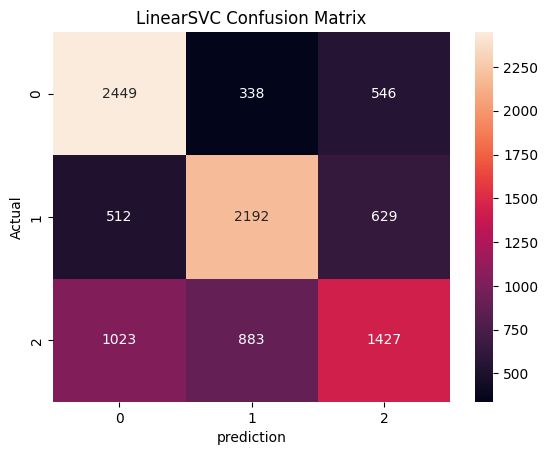

              precision    recall  f1-score   support

           0       0.63      0.73      0.67     29995
           1       0.65      0.68      0.66     29996
           2       0.57      0.45      0.50     29995

    accuracy                           0.62     89986
   macro avg       0.61      0.62      0.61     89986
weighted avg       0.61      0.62      0.61     89986

              precision    recall  f1-score   support

           0       0.61      0.73      0.67      3333
           1       0.64      0.66      0.65      3333
           2       0.55      0.43      0.48      3333

    accuracy                           0.61      9999
   macro avg       0.60      0.61      0.60      9999
weighted avg       0.60      0.61      0.60      9999



In [25]:
trained_clf_svc = LinearSVC().fit(X_train, y_train)
get_accuracy('LinearSVC',trained_clf_svc,X_train, y_train, X_test, y_test)

In [26]:
examples=["خدمة العملاء ممتازة، والشحن سريع جداً. سعيد جداً بتجربتي.","المنتج لا يعمل بشكل جيد، ولاحظت العديد من المشاكل. أنا غير راضٍ."
,"بدأت جيدًا، لكن بعد فترة وجدت بعض المشاكل. يبدو أنه يحتاج إلى تحسين."]

examples_vextors=[preprocess_and_vectorize(example) for example in examples]


In [27]:
trained_clf_sgd.predict(examples_vextors)

array([1, 0, 0])

In [28]:
trained_clf_random_forest.predict(examples_vextors)

array([1, 0, 0])

In [29]:
trained_clf_svc.predict(examples_vextors)

array([1, 0, 2])